Problem:
A list of n prime numbers and a target sum will be given. The task is to find the pair numbers whose sum is equal to the target sum.

Befor solving the problem using quantum algorithm, let's solve it in classical way.

In [1]:
def find_pairs(nums, target_sum):
    for i in range(len(nums)):
        required_val = target_sum - nums[i]
        for j in range(i, len(nums)):
            if nums[j] == required_val:
                return (nums[i], nums[j])
    return "Not Found"

In [2]:
find_pairs( [2,3,5,7,11], 7)

(2, 5)

The wost case time complexity of this algorithm is O(n^2). This function can be optimized using Dynamic Programming which will bring down the complexity to O(n * target_num). But if the target number is close to n then the complexity will be O($n^2$).

The complexity of the implemented function is O($n^2$) becasue for each element ( O(n) ) it has search the array in linear time ( O(n) ). Now we can optimize this algorithm using Grover's algorithm by reducing the searching complexity to O($\sqrt{n}$) and the worst case complexity of findng the pair of prime numbers that sum up to a target sum will be O(n $\sqrt{n}$ ).

Now let's solve the problem using Grover's search.

In [12]:
! pip install -q qiskit pylatexenc pdflatex numpy qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.7 MB/s eta 0:00:00


In [5]:
import numpy as np
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_histogram
from qiskit import IBMQ, Aer, transpile, execute

**Initialization**

First, we have to create an equal superposition of the input prime numbers. The number of qubits will be  equal the bit length of the target. As all the prime numbers are positive, we can safely discard the prime numbers that are bigger than the target sum.

Also, repeated occurance of any value will be omitted so that all possible values have equal amplitude. Consequently, situations where the target sum can be achieved by adding repeated occurrences of a prime number cannot be addressed using this algorithm. For instance, if the prime numbers list includes {2, 3, 3, 5} and the target sum is 6 (resulting from 3+3), this algorithm would not be capable of solving the problem due to its inability to consider repeated occurrences.



In [7]:
def get_initialization_vector(numbers, highest_value):
    '''
    Returns statevector of equal superpositon the given numbers which are less than or
    equal to the highest value.

    Args
    -------
    numbers: list
        A list of given numbers
    highest_value: int
        Numbers upto this value will be represented
    '''
    num_qubits = highest_value.bit_length()
    value_vec = np.zeros(2**num_qubits)
    for num in numbers:
        if num <= highest_value:
            value_vec[num] = 1

    norm = np.linalg.norm(value_vec)
    initial_vector = Statevector(value_vec/norm)
    return initial_vector

**Oracle**

Oracles ($U_{w}$)  add a negative phase to the solution states so they can standout from the rest and be measured. If w is the solution state then-
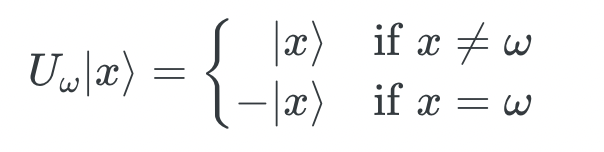

We can create an oracel by replacing 1 by -1 in an identity matrix. The resultant matrix is unitary, so we can create an operator using this matrix.

In [8]:
def get_oracle(target_num, num_qubits):
    '''
    Returns oracle operator which will add negative phase to the target state.
    Args
    ----
    target_num: int
        The solution state
    num_qubits: int
        $(2^num_qubits x 2^num_qubits) will be the size of oracel

    '''
    I = np.identity(2**num_qubits)
    I[target_num][target_num] = -1
    oracle_mat = I
    oracle = Operator(oracle_mat)
    return oracle

**Diffuser**

Diffuser ( $U_{g}$) is used to amplify the amplitude of the target state. It is responsible for enhancing the probability amplitude of the correct solution while suppressing the amplitude of the incorrect states.

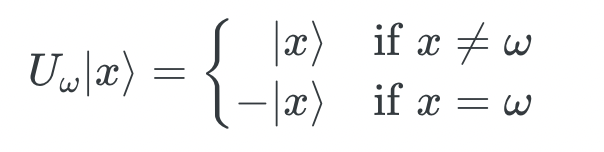


Here, |g> is the initialization vector.

Reference: __[Grover’s Algorithm with Diffusion and Amplitude Steering](https://arxiv.org/pdf/2110.11163.pdf)__

In [9]:
def get_diffuser(initial_vector, num_qubits):
    '''
    Returns diffuser operator

    Args
    ----
    initial_vector: <class 'qiskit.quantum_info.states.statevector.Statevector'>
        Statevector representing equal superposition of the given values
    num_qubits: int
        Number of qubits used

    '''
    G = np.matrix(initial_vector)
    G_T = G.H

    diffuser = Operator(np.identity(2**num_qubits) - 2 * np.outer(G, G_T))

    return diffuser

**Grover's Search**

In Grover's search, the oracel and diffuser is repeated $(pi/4*\sqrt{n})$ times.

In [19]:
def find_the_primes_numbers(target_sum, primeNumbers):
    '''
    Finds a pair of numbers from primeNumbers that sums to target_sum
    and returns the counts of the simulation for that pair.

    Args
    ----
    primeNumbers: list
        A list of prime numbers
    target_sum: int
        target value
    '''
    num_qubits = target_sum.bit_length()
    # get initialization vector
    initial_vector = get_initialization_vector(primeNumbers, target_sum)
    # get the diffuser
    diffuser = get_diffuser(initial_vector, num_qubits)
    # calculate repeat for amplification
    repeat = int((np.pi / 4 * np.sqrt(len(primeNumbers)))//1)
    # quantum simulator
    qasm_sim = Aer.get_backend('qasm_simulator')

    for num in primeNumbers:
        target_num = target_sum - num

        if target_num == num:
            print("The target sum is double of a prime number. This case can not be solved using this implementation.")
            continue
        if target_num <= 0:
            continue

        # get oracle for target_num value
        oracle = get_oracle(target_num,num_qubits)

        # build the circuit
        qc = QuantumCircuit(num_qubits)
        qc.initialize(initial_vector, range(num_qubits))

        for _ in range(repeat):
            qc.append(oracle, range(num_qubits))
            qc.append(diffuser, range(num_qubits))

        qc.measure_all()
        result = qasm_sim.run(qc).result()
        counts = result.get_counts()

        for count in counts.values():
            if count > 500:
                print(f"PAIR FOUND: ({num},{target_num}) from the list of primes numbers sums to {target_sum}\n")
                return counts
    print("NO PAIR FOUND")
    return {0:0}


PAIR FOUND: (3,15) from the list of primes numbers sums to 18



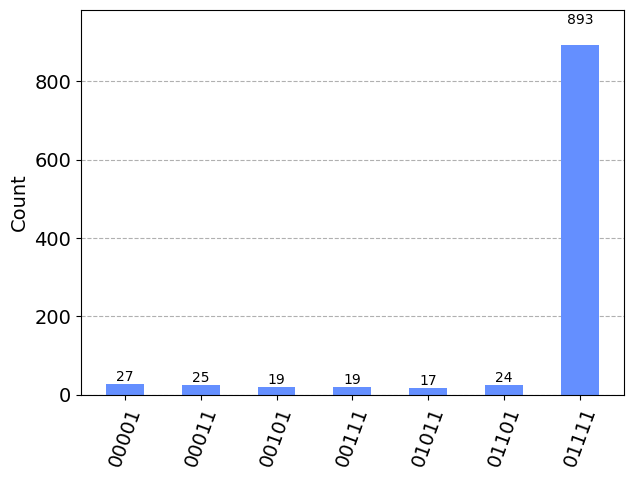

In [20]:
counts = find_the_primes_numbers (18,[1,3,5,7,11,13,15])

plot_histogram(counts)

PAIR FOUND: (11,29) from the list of primes numbers sums to 40



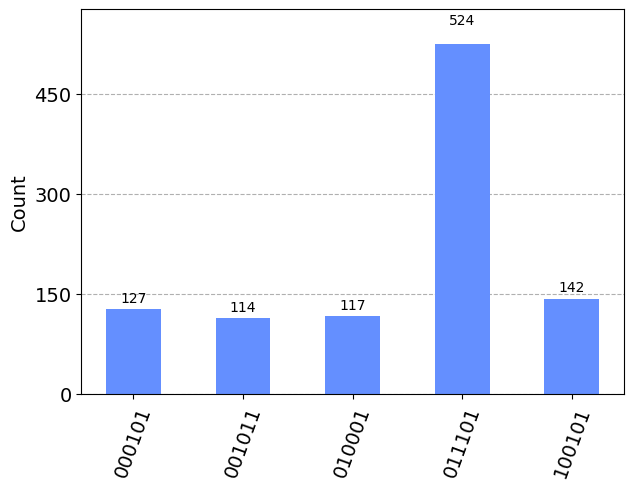

In [21]:
counts = find_the_primes_numbers(40, [5, 11, 17, 29, 37, 41, 53, 59, 67, 71])
plot_histogram(counts)

**In this notebook, I have successfully implemented Grover's algorithm to find a pair of prime numbers from a given list whose sum is equal to a target value.**

This implementation won't able to find the pair if the two elements are same. Here is an example-

In [22]:
find_the_primes_numbers (6,[2,3,3,5])

The target sum is double of a prime number. This case can not be solved using this implementation.
The target sum is double of a prime number. This case can not be solved using this implementation.
NO PAIR FOUND


{0: 0}

But if there is another solution, that pair will be found by this implementation. For the following exmple, target sum can be obtained summing 5 twice and summing 3 & 7. (3,5) will be found by the algorithm.

In [23]:
find_the_primes_numbers (10,[5,3,7,5])

The target sum is double of a prime number. This case can not be solved using this implementation.
PAIR FOUND: (3,7) from the list of primes numbers sums to 10



{'0101': 27, '0011': 35, '0111': 962}